In [560]:
# Importing the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import load_img, img_to_array

In [562]:
data = pd.read_csv('fer2013.csv')

In [564]:
data

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
...,...,...,...
35882,6,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...,PrivateTest
35883,3,178 174 172 173 181 188 191 194 196 199 200 20...,PrivateTest
35884,0,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...,PrivateTest
35885,3,30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...,PrivateTest


In [566]:
data.columns

Index(['emotion', 'pixels', 'Usage'], dtype='object')

In [568]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35887 entries, 0 to 35886
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  35887 non-null  int64 
 1   pixels   35887 non-null  object
 2   Usage    35887 non-null  object
dtypes: int64(1), object(2)
memory usage: 841.2+ KB


In [570]:
data.describe()

,emotion
count,35887.000000
mean,3.323265
std,1.873819
min,0.000000
25%,2.000000
50%,3.000000
75%,5.000000
max,6.000000


In [572]:
data.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [574]:
data['emotion'].value_counts()

emotion
3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: count, dtype: int64

In [576]:
data.isnull().sum()

emotion    0
pixels     0
Usage      0
dtype: int64

In [578]:
# Prepare the image data
X = []
y = []

In [22]:
for i, row in data.iterrows():
    pixels = np.array(row['pixels'].split(), dtype='float32')
    pixels = pixels.reshape(48, 48, 1)  # Reshape into 48x48 grayscale image
    X.append(pixels)
    y.append(row['emotion'])

In [24]:
# Now convert it to a numpy array
X = np.array(X)
y = to_categorical(np.array(y), num_classes=7)

In [26]:
X = X/255.0

In [28]:
# Splitting the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X,y, test_size=0.2, random_state=42)

In [30]:
X_train.shape[0] # Training samples

28709

In [32]:
X_val.shape[0] # Validation samples

7178

### Building the CNN(Convolutional Neural Networks) Model

In [34]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

def build_model(input_shape):
    model = Sequential()

    # 1st Convolutional Layer
    model.add(Conv2D(64, (3, 3), activation='relu', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    # 2nd Convolutional Layer
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    # 3rd Convolutional Layer
    model.add(Conv2D(256, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Flatten before entering Dense layers
    model.add(Flatten())

    # Dense layer with dropout for regularization
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    
    # Output layer with 7 emotions
    model.add(Dense(7, activation='softmax'))

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# Build and print model summary
model = build_model((48, 48, 1))
model.summary()





Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 64)        640       
                                                                 
 batch_normalization (Batch  (None, 46, 46, 64)        256       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 23, 23, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 21, 21, 128)       73856     
                                                                 
 batch_normalization_1 (Bat  (None, 21, 21, 128)       512       
 chNormalization)                                                
                                                     

### Train the Model

In [36]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [38]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_emotion_model.h5', monitor='val_accuracy', save_best_only=True)

In [42]:
## Now we'll train the model

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=54,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/50


532/532 [==============================] - ETA: 0s - loss: 1.7740 - accuracy: 0.3447

C:\Users\OMDEEP\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


532/532 [==============================] - 108s 199ms/step - loss: 1.7740 - accuracy: 0.3447 - val_loss: 1.5445 - val_accuracy: 0.3883
Epoch 2/50
532/532 [==============================] - 105s 198ms/step - loss: 1.4348 - accuracy: 0.4445 - val_loss: 1.6310 - val_accuracy: 0.3809
Epoch 3/50
532/532 [==============================] - 107s 201ms/step - loss: 1.3349 - accuracy: 0.4852 - val_loss: 1.4119 - val_accuracy: 0.4411
Epoch 4/50
532/532 [==============================] - 124s 234ms/step - loss: 1.2582 - accuracy: 0.5146 - val_loss: 1.5888 - val_accuracy: 0.3671
Epoch 5/50
532/532 [==============================] - 110s 208ms/step - loss: 1.1934 - accuracy: 0.5421 - val_loss: 1.2360 - val_accuracy: 0.5308
Epoch 6/50
532/532 [==============================] - 112s 210ms/step - loss: 1.1158 - accuracy: 0.5684 - val_loss: 2.1015 - val_accuracy: 0.3922
Epoch 7/50
532/532 [==============================] - 116s 219ms/step - loss: 1.0401 - accuracy: 0.6025 - val_loss: 1.7210 - val_accura

In [44]:
# save the model
model.save('emotion_detection_model.h5')

C:\Users\OMDEEP\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [50]:
model.save('my_model.keras')

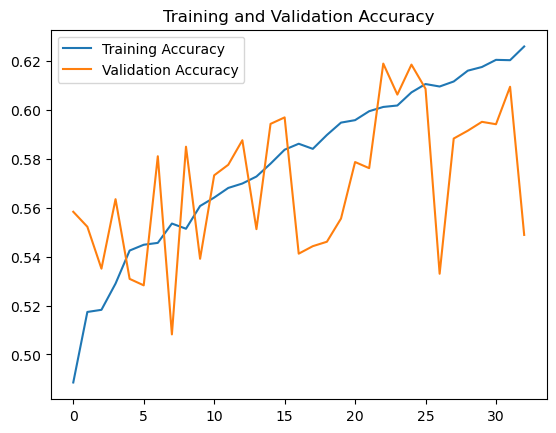

In [580]:
## Plot training history
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

### Evaluate the Model
> Evaluate the model based on the validation set

In [48]:
val_loss, val_acc = model.evaluate(X_val, y_val)
print(f'Validation accuracy: {val_acc:.4f}')

225/225 [==============================] - 7s 33ms/step - loss: 1.2215 - accuracy: 0.5515
Validation accuracy: 0.5515


## Fine Tuning

In [326]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [328]:
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

In [330]:
datagen.fit(X_train)

In [117]:
# Now Train the model using the augmented data
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=64),
    validation_data=(X_val, y_val),
    epochs=50,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/50
449/449 [==============================] - 106s 233ms/step - loss: 1.3498 - accuracy: 0.4886 - val_loss: 1.2003 - val_accuracy: 0.5584
Epoch 2/50
449/449 [==============================] - 114s 253ms/step - loss: 1.2833 - accuracy: 0.5174 - val_loss: 1.1827 - val_accuracy: 0.5522
Epoch 3/50
449/449 [==============================] - 109s 242ms/step - loss: 1.2753 - accuracy: 0.5183 - val_loss: 1.2165 - val_accuracy: 0.5351
Epoch 4/50
449/449 [==============================] - 105s 234ms/step - loss: 1.2466 - accuracy: 0.5290 - val_loss: 1.1505 - val_accuracy: 0.5635
Epoch 5/50
449/449 [==============================] - 104s 233ms/step - loss: 1.2246 - accuracy: 0.5425 - val_loss: 1.2206 - val_accuracy: 0.5309
Epoch 6/50
449/449 [==============================] - 109s 243ms/step - loss: 1.2122 - accuracy: 0.5449 - val_loss: 1.2363 - val_accuracy: 0.5283
Epoch 7/50
449/449 [==============================] - ETA: 0s - loss: 1.2097 - accuracy: 0.5456

C:\Users\OMDEEP\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


449/449 [==============================] - 108s 241ms/step - loss: 1.2097 - accuracy: 0.5456 - val_loss: 1.1172 - val_accuracy: 0.5811
Epoch 8/50
449/449 [==============================] - 103s 230ms/step - loss: 1.1854 - accuracy: 0.5536 - val_loss: 1.3007 - val_accuracy: 0.5082
Epoch 9/50
449/449 [==============================] - 146s 325ms/step - loss: 1.1892 - accuracy: 0.5514 - val_loss: 1.1135 - val_accuracy: 0.5850
Epoch 10/50
449/449 [==============================] - 105s 233ms/step - loss: 1.1780 - accuracy: 0.5607 - val_loss: 1.2465 - val_accuracy: 0.5391
Epoch 11/50
449/449 [==============================] - 110s 245ms/step - loss: 1.1607 - accuracy: 0.5642 - val_loss: 1.1362 - val_accuracy: 0.5733
Epoch 12/50
449/449 [==============================] - 112s 250ms/step - loss: 1.1479 - accuracy: 0.5681 - val_loss: 1.1348 - val_accuracy: 0.5776
Epoch 13/50
449/449 [==============================] - 107s 237ms/step - loss: 1.1459 - accuracy: 0.5699 - val_loss: 1.1047 - val_ac

### Exploratory Data Analysis(EDA)
> We'll perform EDA

In [582]:
# Data correlation
import seaborn as sns

data.dtypes

emotion     int64
pixels     object
Usage      object
dtype: object

In [584]:
data['emotion'] = pd.to_numeric(data['emotion'], errors='coerce')

In [586]:
data = data.select_dtypes(include=[np.number])
data = data.dropna()


<Axes: >

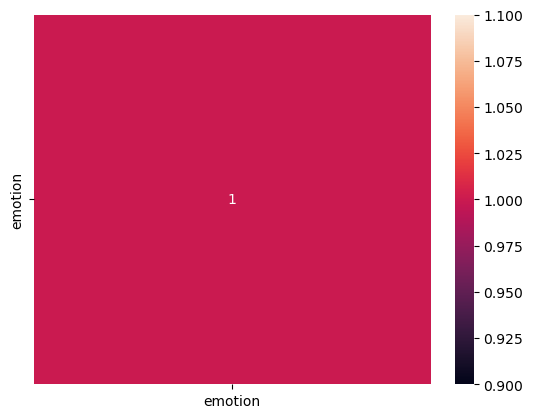

In [588]:
sns.heatmap(data.corr(), annot=True)

In [590]:
data.describe()

,emotion
count,35887.000000
mean,3.323265
std,1.873819
min,0.000000
25%,2.000000
50%,3.000000
75%,5.000000
max,6.000000


In [592]:
data['emotion'].unique()

array([0, 2, 4, 6, 3, 5, 1], dtype=int64)

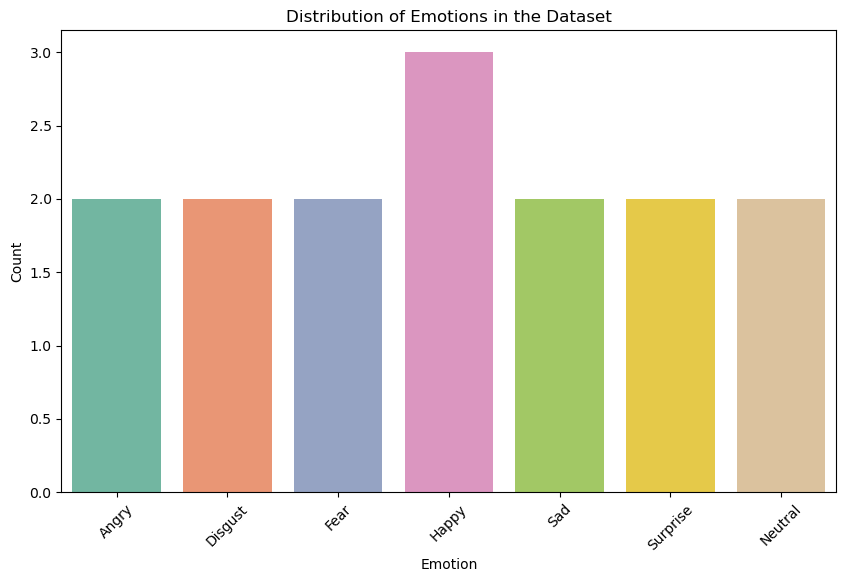

In [660]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Example DataFrame with numeric emotions
data = pd.DataFrame({
    'emotion': [0, 1, 2, 3, 4, 3, 5, 6, 0, 1, 2, 3, 4, 5, 6]
})

# Emotion labels mapping
emotion_labels = {
    0: 'Angry',
    1: 'Disgust',
    2: 'Fear',
    3: 'Happy',
    4: 'Sad',
    5: 'Surprise',
    6: 'Neutral'
}

# Replace numeric values in the 'emotion' column with emotion names
data['emotion'] = data['emotion'].map(emotion_labels)

# Check for NaN values after mapping
if data['emotion'].isnull().any():
    print("Warning: There are NaN values in the 'emotion' column after mapping.")

# Create the count plot with emotion names on x-axis
plt.figure(figsize=(10, 6))
sns.countplot(x='emotion', data=data, palette='Set2')
plt.title('Distribution of Emotions in the Dataset')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.xticks(rotation=45)  # Optional: rotate the x-axis labels for better visibility
plt.show()

In [594]:
emotion = data.emotion.value_counts().index
emotion

Index([3, 6, 4, 2, 0, 5, 1], dtype='int64', name='emotion')

In [596]:
emotion=data.emotion.value_counts().values

In [598]:
emotion

array([8989, 6198, 6077, 5121, 4953, 4002,  547], dtype=int64)

Text(0.5, 1.0, 'Arrays of emotions')

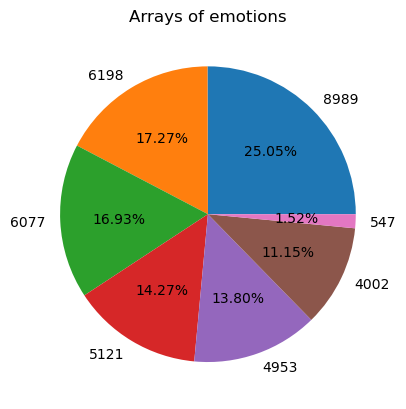

In [600]:
plt.pie(emotion[:7], labels=emotion[:7],autopct='%1.2f%%')
plt.title('Arrays of emotions')

In [602]:
data['emotion'].unique()

array([0, 2, 4, 6, 3, 5, 1], dtype=int64)

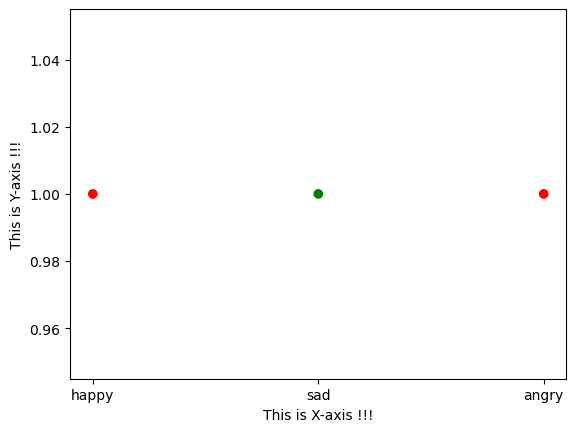

In [604]:
import matplotlib.pyplot as plt
import pandas as pd

# Sample DataFrame for demonstration
data = {'emotion': ['happy', 'sad', 'angry'], 'pixels': ['emotion', 'pixels', 'emotion']}
df = pd.DataFrame(data)

colors_emotion = {"emotion": "red", "pixels": "green"}

# Ensure that the values in df["pixels"] are valid keys in colors_emotion
df['color'] = df["pixels"].apply(lambda col: colors_emotion.get(col, 'black'))  # Default to 'black' if key not found

plt.scatter(df['emotion'], [1]*len(df), c=df['color'])  # Example y-values
plt.xlabel("This is X-axis !!!")
plt.ylabel("This is Y-axis !!!")
plt.show()

In [606]:
 df = pd.DataFrame(data)
print(df.columns)

Index(['emotion', 'pixels'], dtype='object')


In [608]:
data = pd.DataFrame({
    'emotion': ['happy', 'sad', 'happy', 'angry', 'neutral', 'disgust'],
    'count': [1, 2, 3, 4, 5, 6]
})
emotion = data.groupby('emotion').size().reset_index(name='count')

print(emotion)

   emotion  count
0    angry      1
1  disgust      1
2    happy      2
3  neutral      1
4      sad      1


### Data Cleaning

In [611]:
df = pd.read_csv('fer2013.csv')

In [613]:
df

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
...,...,...,...
35882,6,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...,PrivateTest
35883,3,178 174 172 173 181 188 191 194 196 199 200 20...,PrivateTest
35884,0,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...,PrivateTest
35885,3,30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...,PrivateTest


In [615]:
df.duplicated()

0        False
1        False
2        False
3        False
4        False
         ...  
35882    False
35883    False
35884    False
35885    False
35886    False
Length: 35887, dtype: bool

In [617]:
df['emotion'].unique()

array([0, 2, 4, 6, 3, 5, 1], dtype=int64)

In [619]:
df['pixels'].unique()

array(['70 80 82 72 58 58 60 63 54 58 60 48 89 115 121 119 115 110 98 91 84 84 90 99 110 126 143 153 158 171 169 172 169 165 129 110 113 107 95 79 66 62 56 57 61 52 43 41 65 61 58 57 56 69 75 70 65 56 54 105 146 154 151 151 155 155 150 147 147 148 152 158 164 172 177 182 186 189 188 190 188 180 167 116 95 103 97 77 72 62 55 58 54 56 52 44 50 43 54 64 63 71 68 64 52 66 119 156 161 164 163 164 167 168 170 174 175 176 178 179 183 187 190 195 197 198 197 198 195 191 190 145 86 100 90 65 57 60 54 51 41 49 56 47 38 44 63 55 46 52 54 55 83 138 157 158 165 168 172 171 173 176 179 179 180 182 185 187 189 189 192 197 200 199 196 198 200 198 197 177 91 87 96 58 58 59 51 42 37 41 47 45 37 35 36 30 41 47 59 94 141 159 161 161 164 170 171 172 176 178 179 182 183 183 187 189 192 192 194 195 200 200 199 199 200 201 197 193 111 71 108 69 55 61 51 42 43 56 54 44 24 29 31 45 61 72 100 136 150 159 163 162 163 170 172 171 174 177 177 180 187 186 187 189 192 192 194 195 196 197 199 200 201 200 197 201 137 5

In [621]:
df['Usage'].unique()

array(['Training', 'PublicTest', 'PrivateTest'], dtype=object)

In [623]:
df['emotion'].value_counts()

emotion
3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: count, dtype: int64

In [625]:
df['pixels'].value_counts()

pixels
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

In [627]:
df['Usage'].value_counts()

Usage
Training       28709
PublicTest      3589
PrivateTest     3589
Name: count, dtype: int64

In [629]:
df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [631]:
df.describe()

,emotion
count,35887.000000
mean,3.323265
std,1.873819
min,0.000000
25%,2.000000
50%,3.000000
75%,5.000000
max,6.000000


In [633]:
df.isnull().sum()

emotion    0
pixels     0
Usage      0
dtype: int64

### Preprocessing Pixel Data

In [636]:
def preprocess_pixels(pixel_str):
    pixels = np.array(pixel_str.split(), dtype=int)
    return pixels.reshape(48,48)

df['pixels'] = df['pixels'].apply(preprocess_pixels)

In [638]:
# Encoding categorical variables
df['Usage'] = df['Usage'].astype('category').cat.codes

### Feature Scaling

In [640]:
df['pixels'] = df['pixels']/255.0

In [642]:
## We'll now Split the data
train_df = df[df['Usage'] == 0]
public_test_df = df[df['Usage'] == 1]
private_test_df = df[df['Usage'] == 2]

### Performing EDA

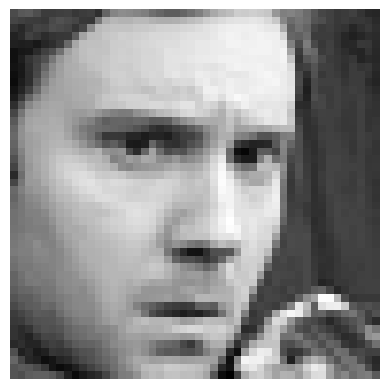

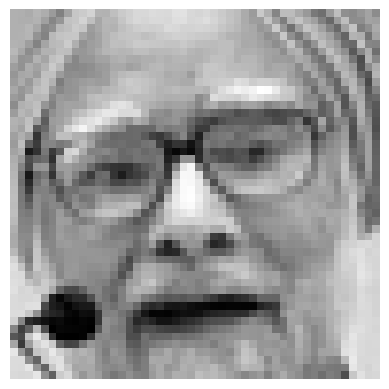

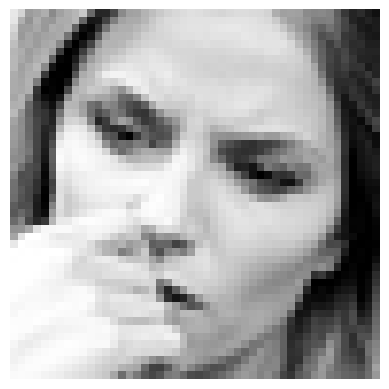

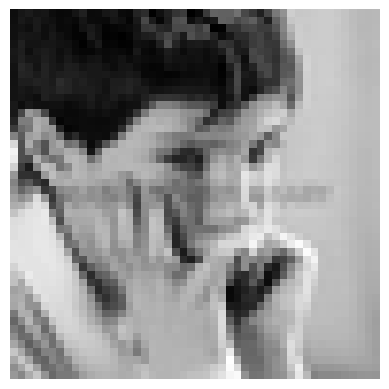

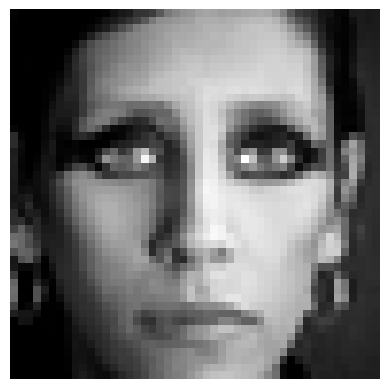

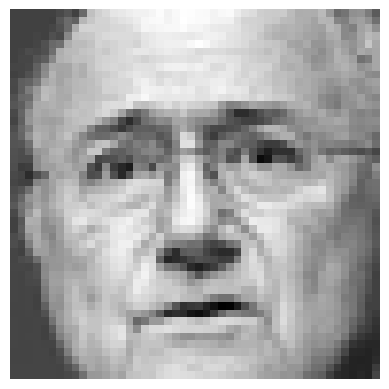

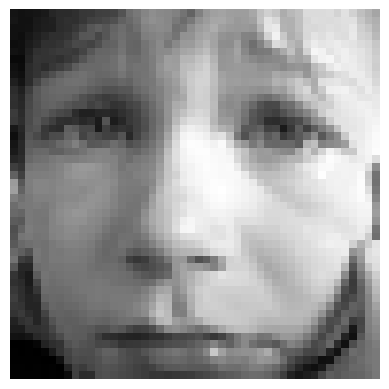

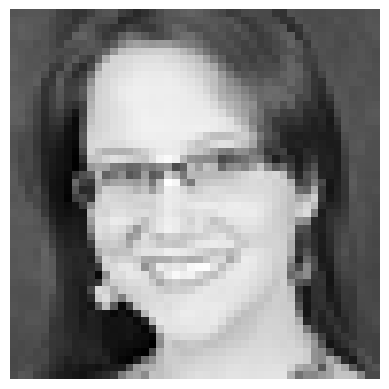

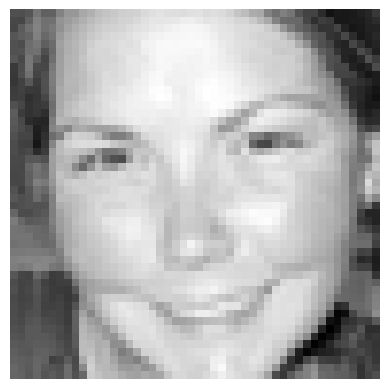

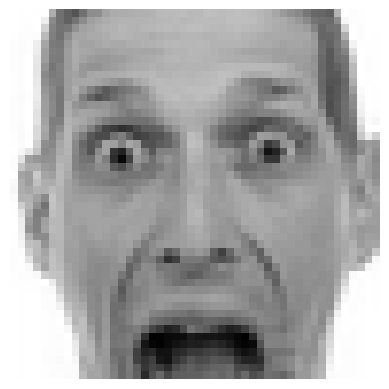

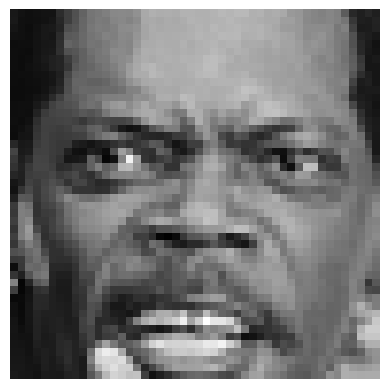

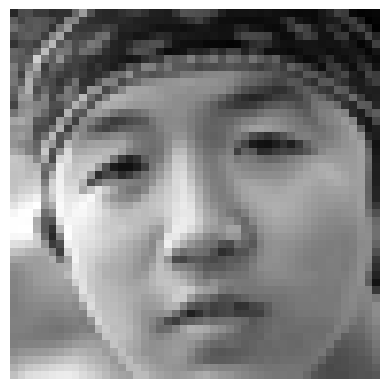

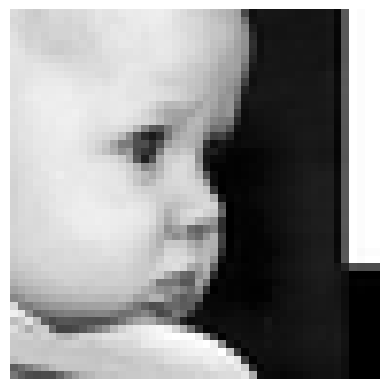

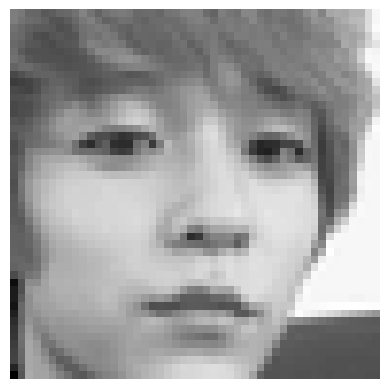

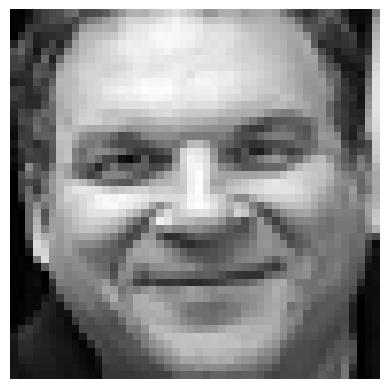

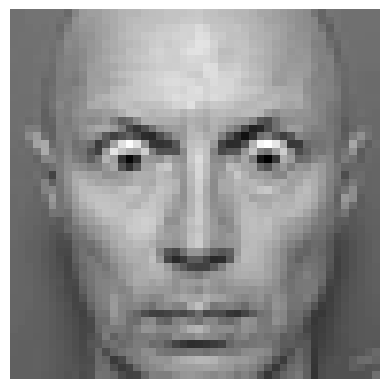

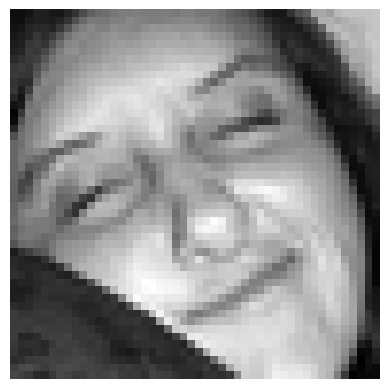

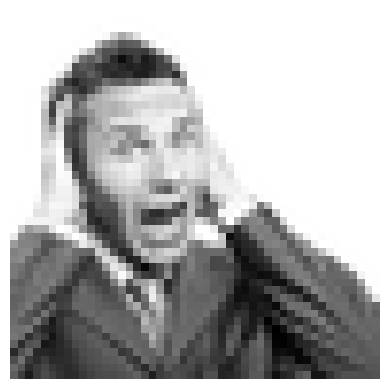

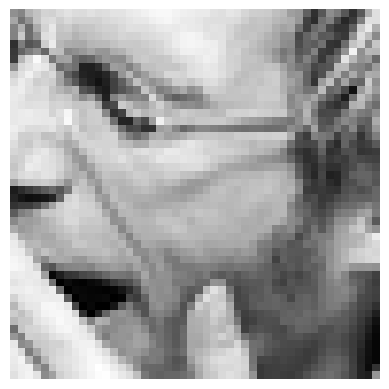

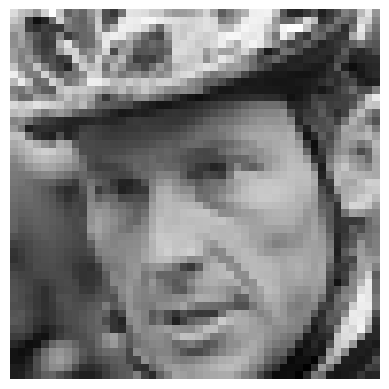

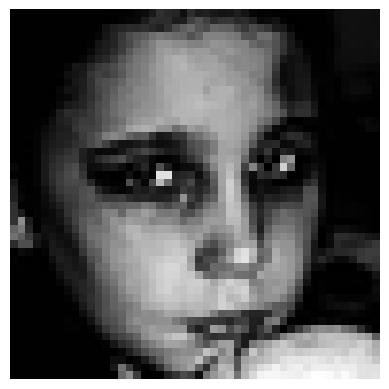

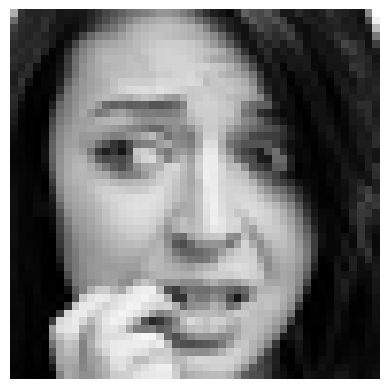

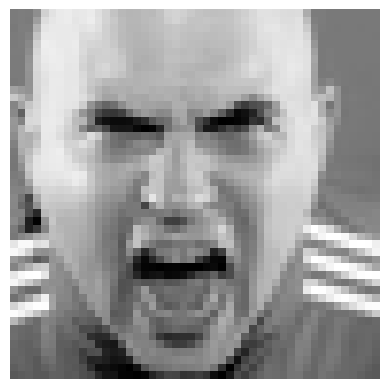

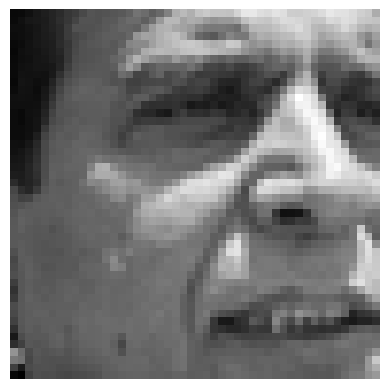

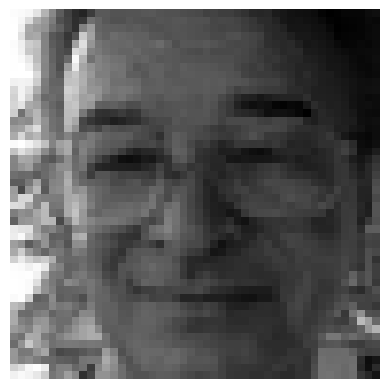

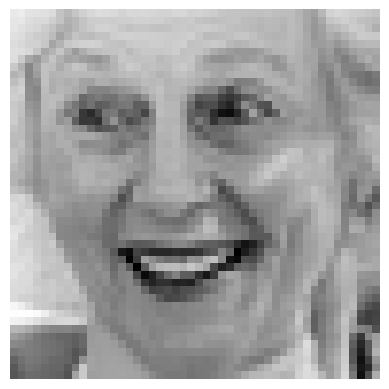

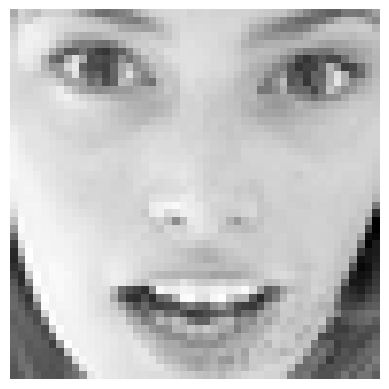

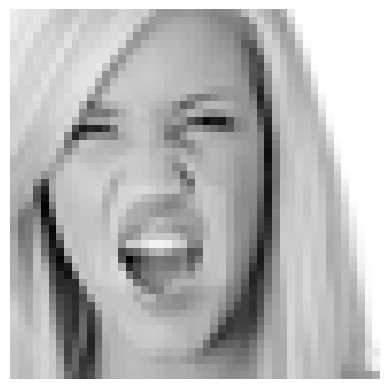

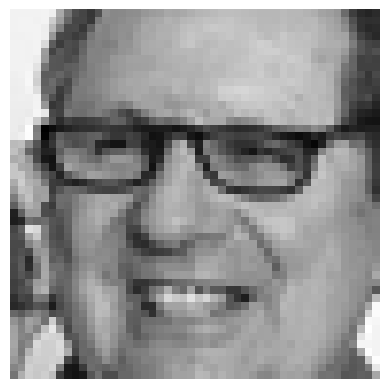

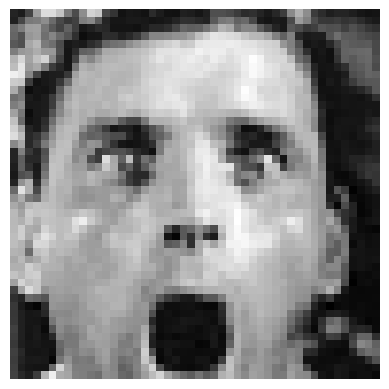

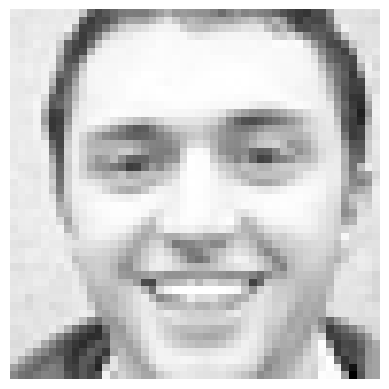

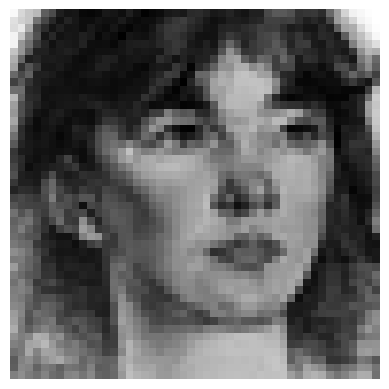

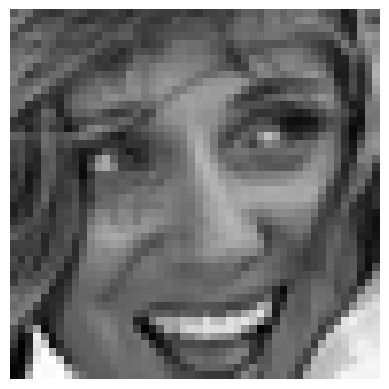

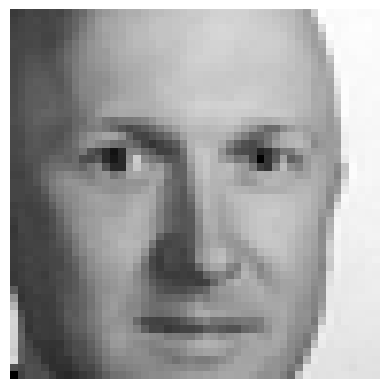

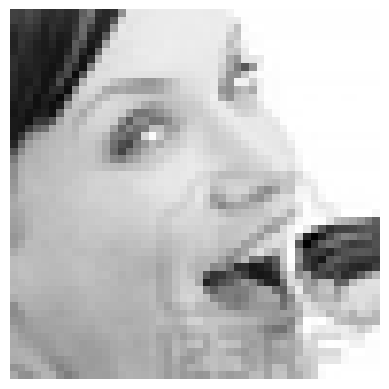

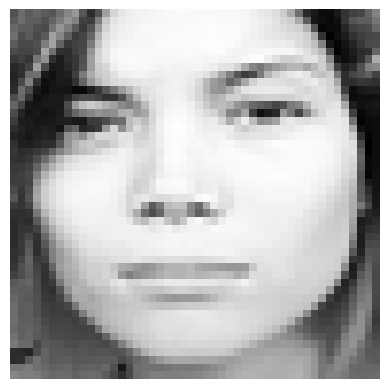

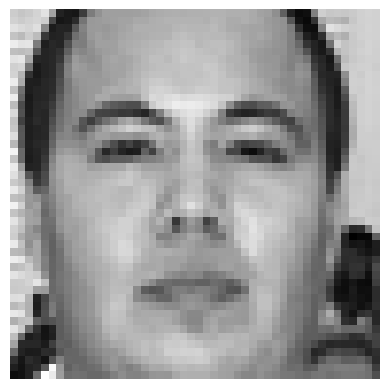

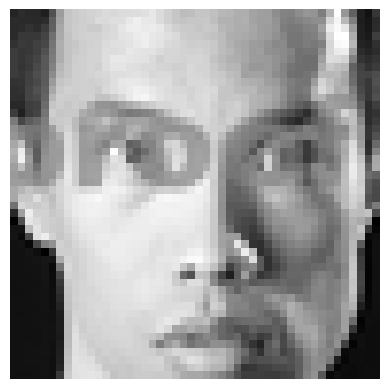

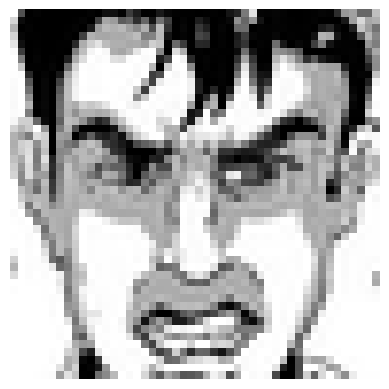

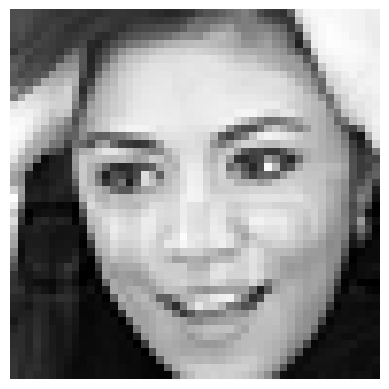

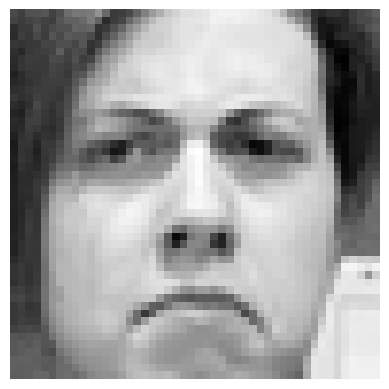

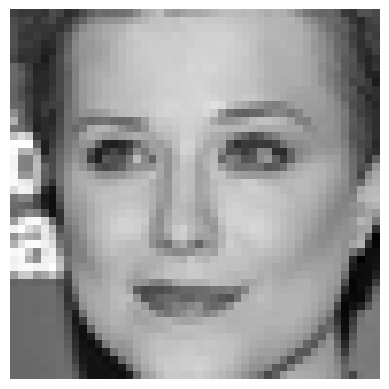

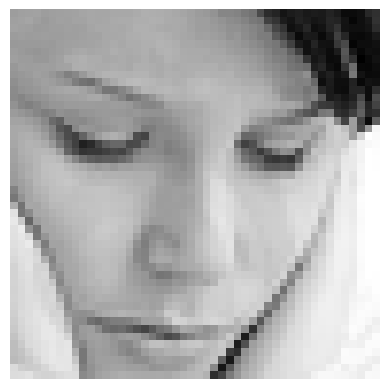

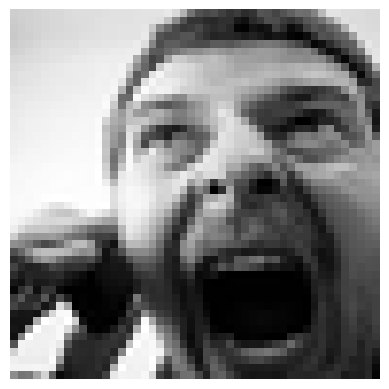

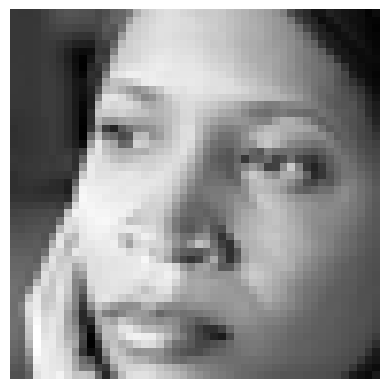

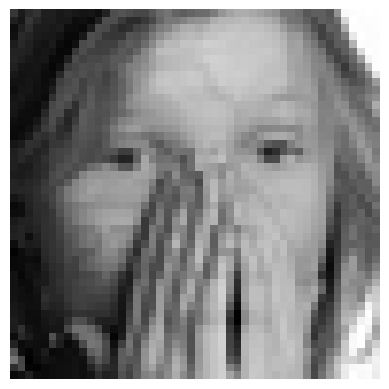

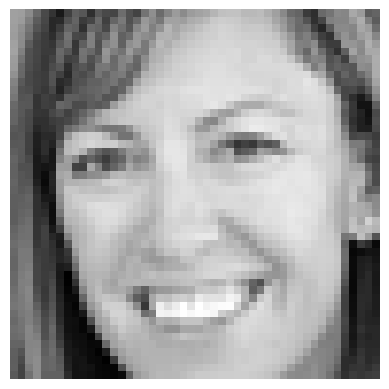

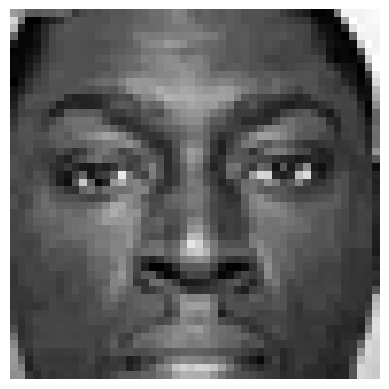

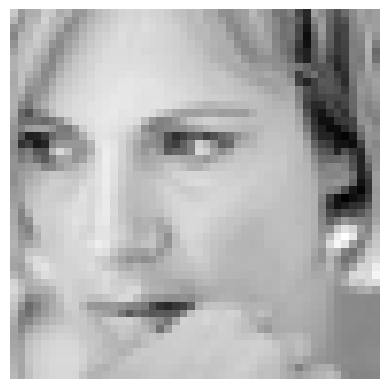

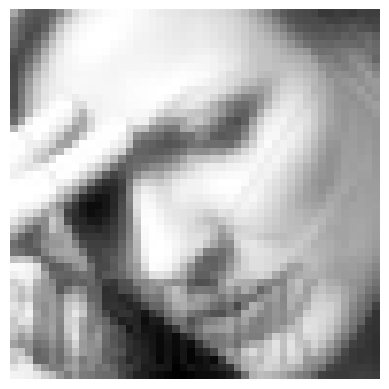

In [644]:
import matplotlib.pyplot as plt

def plot_image(pixels):
    plt.imshow(pixels, cmap='gray')
    plt.axis('off')
    plt.show()

# Display a few sample images
for i in range(50):
    plot_image(df['pixels'].iloc[i])


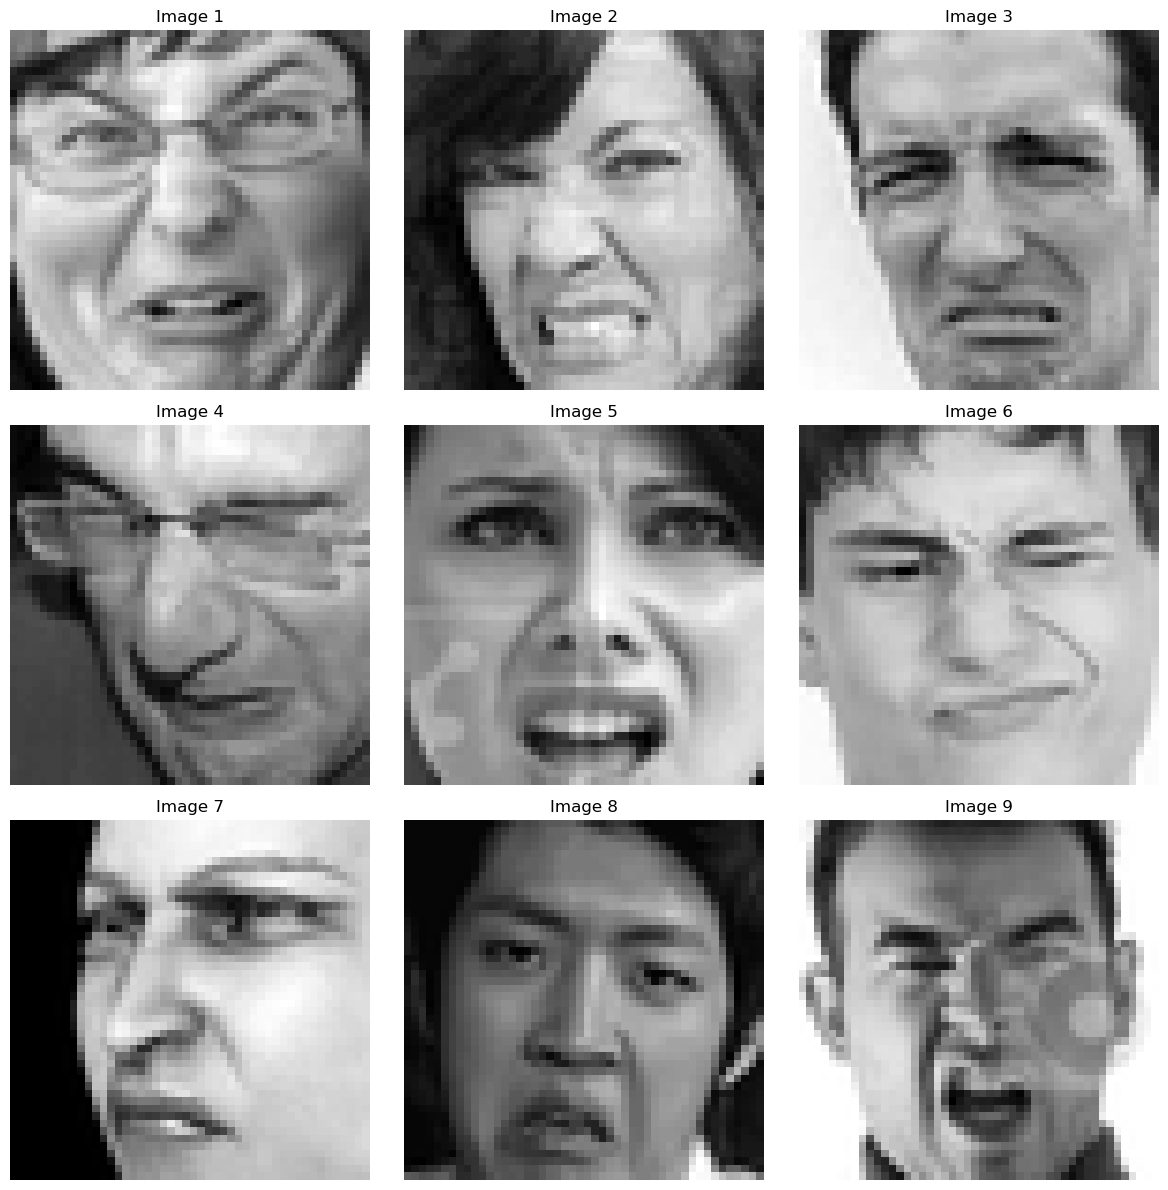

In [645]:
def plot_image(pixels, title=None):
    plt.imshow(pixels, cmap='gray')
    plt.axis('off')
    if title:
        plt.title(title)
    plt.show()

expression = 1
filtered_df = df[df['emotion'] == expression]

# Display a few sample images for the specified expression
num_images_to_show = 9
plt.figure(figsize=(12,12))

for i in range(min(num_images_to_show, len(filtered_df))):
    plt.subplot(3, 3, i + 1)
    img_pixels = np.array(filtered_df['pixels'].iloc[i]) 
    plt.imshow(img_pixels, cmap='gray')
    plt.axis('off')
    plt.title(f'Image {i+1}')

plt.tight_layout()
plt.show()

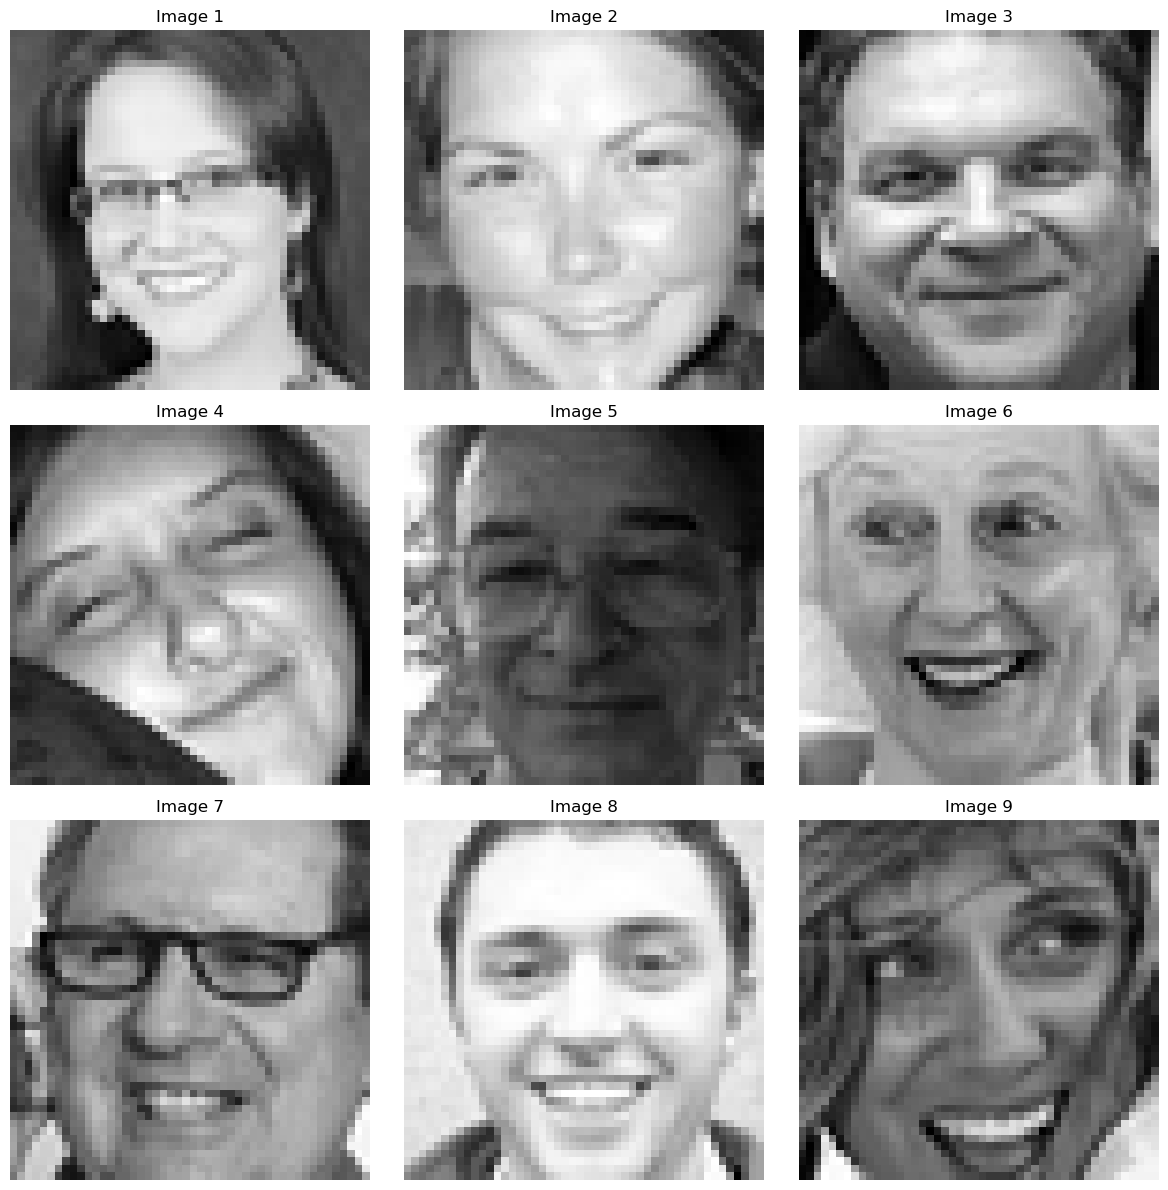

In [509]:
def plot_image(pixels, title=None):
    plt.imshow(pixels, cmap='gray')
    plt.axis('off')
    if title:
        plt.title(title)
    plt.show()

expression = 3
filtered_df = df[df['emotion'] == expression]

# Display a few sample images for the specified expression
num_images_to_show = 9
plt.figure(figsize=(12,12))

for i in range(min(num_images_to_show, len(filtered_df))):
    plt.subplot(3, 3, i + 1)
    img_pixels = np.array(filtered_df['pixels'].iloc[i]) 
    plt.imshow(img_pixels, cmap='gray')
    plt.axis('off')
    plt.title(f'Image {i+1}')

plt.tight_layout()
plt.show()

In [513]:
df['pixels'].iloc[0].min(), df['pixels'].iloc[0].max()

(0.043137254901960784, 0.8235294117647058)

In [662]:
from mtcnn import MTCNN
import cv2
import numpy as npq
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array
# Load the emotion classifier model
model_path = 'emotion_detection_model.h5'  # Adjust path if needed
classifier = load_model(model_path)

# Initialize MTCNN for face detection
detector = MTCNN()

# Define emotion labels
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

# Start video capture
cap = cv2.VideoCapture(0)
if not cap.isOpened():
    raise IOError("Cannot open webcam.")

while True:
    # Capture frame-by-frame
    ret, frame = cap.read()
    if not ret:
        print("Failed to grab frame.")
        break

    # Detect faces in the frame
    results = detector.detect_faces(frame)

    if not results:
        cv2.putText(frame, 'No Faces Detected', (30, 80), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    for result in results:
        x, y, w, h = result['box']
        x, y, w, h = abs(x), abs(y), x+w, y+h

        # Draw rectangle around face
        cv2.rectangle(frame, (x, y), (w, h), (0, 255, 255), 2)

        # Preprocess the face region
        roi = frame[y:h, x:w]
        roi_gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
        roi_gray = cv2.resize(roi_gray, (48, 48), interpolation=cv2.INTER_AREA)

        if np.sum([roi_gray]) != 0:
            roi = roi_gray.astype('float32') / 255.0
            roi = img_to_array(roi)
            roi = np.expand_dims(roi, axis=0)

            # Predict emotion
            prediction = classifier.predict(roi)[0]
            label = emotion_labels[prediction.argmax()]

            # Display the label on the frame
            label_position = (x, y - 10)  # Position label above the face rectangle
            cv2.putText(frame, label, label_position, cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    # Display the resulting frame
    cv2.imshow('Emotion Detector', frame)

    # Exit on 'q' key press
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release video capture and close windows
cap.release()
cv2.destroyAllWindows()


Cause: Unable to locate the source code of <function Model.make_predict_function.<locals>.predict_function at 0x0000022911EA2AC0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: Unable to locate the source code of <function Model.make_predict_function.<locals>.predict_function at 0x0000022911EA2AC0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Orig

### Saving Cleaned Data
> After preprocessing, save the cleaned dataset for future use.

In [453]:
df.to_csv('cleaned_fer2013.csv', index=False)

### Feature Engineering

In [455]:
data = {
    'emotion': ['happy', 'sad', 'angry', 'happy'],
    'pixels': ['emotion', 'pixels', 'emotion', 'pixels']
    #'Usage': ['Training', 'PublicTest', 'PrivateTest']
}

# Convert the dictionary to a DataFrame
df = pd.DataFrame(data)

# Now you can access the columns
for i in df.columns:
    print(i, ':', len(df[i].unique()), 'labels')

emotion : 3 labels
pixels : 2 labels


In [457]:
emotion_counts = df['emotion'].value_counts()
print(emotion_counts.head(10))

emotion
happy    2
sad      1
angry    1
Name: count, dtype: int64


In [459]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [461]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

# Sample DataFrame
data = {
    'emotion': ['happy', 'sad', 'angry', 'happy', 'sad'],
    'pixels': ['emotion', 'pixels', 'emotion', 'pixels', 'emotion']
}
df = pd.DataFrame(data)

# Encode the 'pixels' column
label_encoder = LabelEncoder()
df['pixels_encoded'] = label_encoder.fit_transform(df['pixels'])

# Split the data
X_train, X_val, y_train, y_val = train_test_split(df[['pixels_encoded']], df['emotion'], test_size=0.2, random_state=42)

# Create and fit the model
model = RandomForestClassifier()
model.fit(X_train, y_train)

# Optionally, you can evaluate the model here


RandomForestClassifier()

In [463]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_val)
print(classification_report(y_val, y_pred))


              precision    recall  f1-score   support

       happy       0.00      0.00      0.00       0.0
         sad       0.00      0.00      0.00       1.0

    accuracy                           0.00       1.0
   macro avg       0.00      0.00      0.00       1.0
weighted avg       0.00      0.00      0.00       1.0



C:\Users\OMDEEP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\OMDEEP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\OMDEEP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\OMDEEP\anaconda3\Lib\site-packages\s

In [326]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

# Sample DataFrame
data = {
    'emotion': ['happy', 'sad', 'angry', 'happy', 'sad'],
    'pixels': ['emotion', 'pixels', 'emotion', 'pixels', 'emotion']
}
df = pd.DataFrame(data)

# Encode the 'pixels' column
label_encoder = LabelEncoder()
df['pixels_encoded'] = label_encoder.fit_transform(df['pixels'])

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(df[['pixels_encoded']], df['emotion'], test_size=0.2, random_state=42)

# Create and fit the model
model = RandomForestClassifier()
model.fit(X_train, y_train)

# Evaluate the model on the validation set
accuracy = model.score(X_val, y_val)
print(f"Model accuracy on validation set: {accuracy:.2f}")


Model accuracy on validation set: 0.00


In [328]:
from sklearn.model_selection import GridSearchCV

param_grid = {'n_estimators': [50, 100], 'max_depth': [10, 20]}
grid_search = GridSearchCV(model, param_grid, cv=5)
grid_search.fit(X_train, y_train)


ValueError: Cannot have number of splits n_splits=5 greater than the number of samples: n_samples=4.

In [330]:
import joblib

joblib.dump(model, 'model.pkl')


['model.pkl']